#Data Pipeline Architecture
In this code, I present you the data pipeline architecture in the below flowchart.

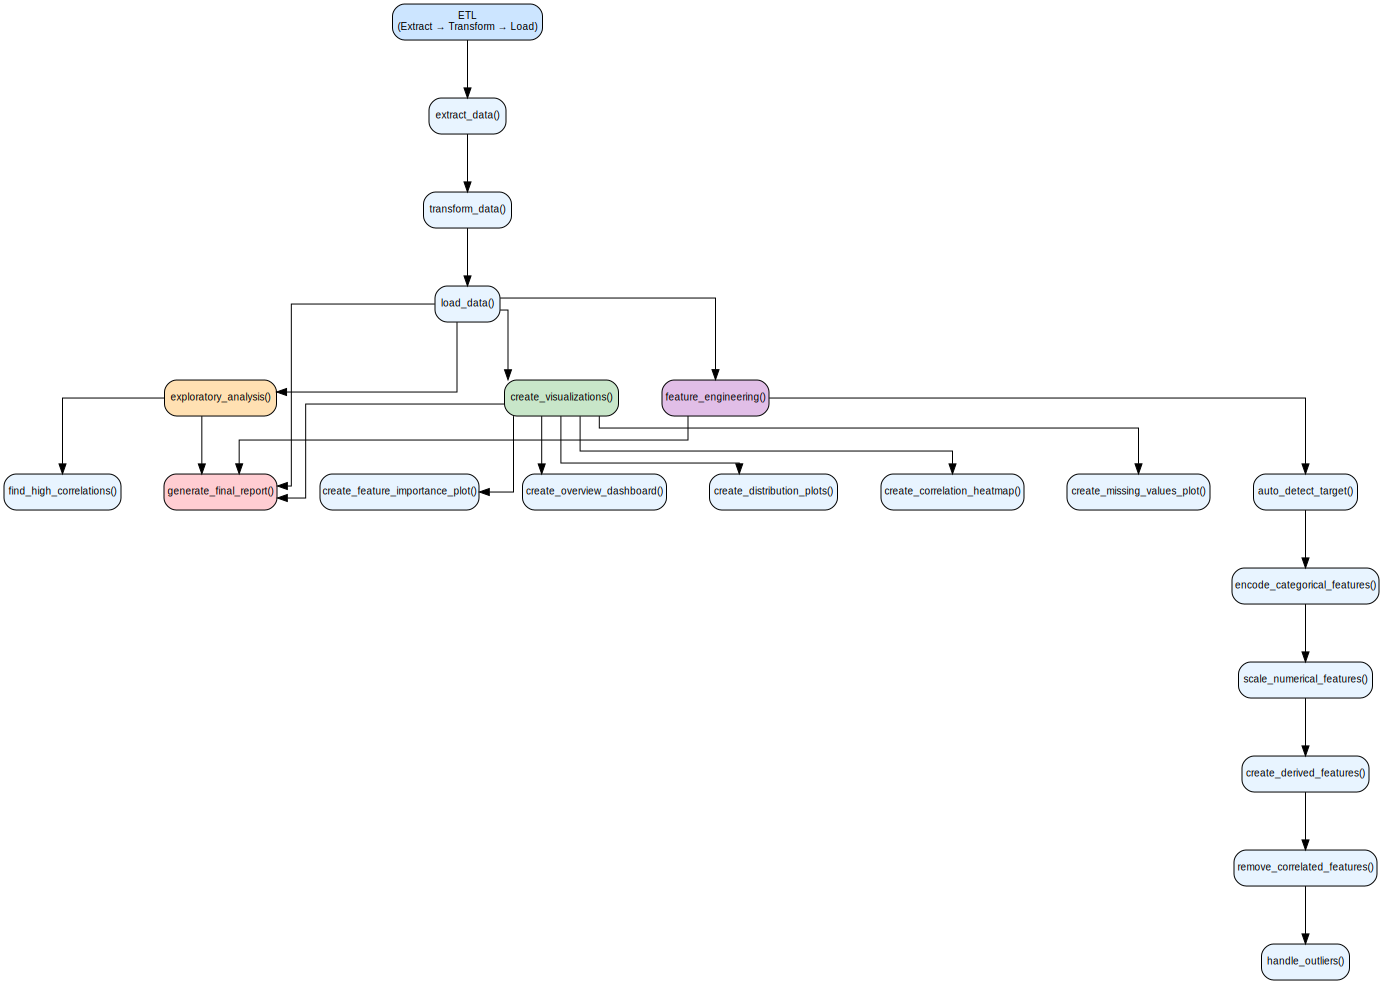

In [5]:
from graphviz import Digraph

def show_pipeline_flowchart():
    dot = Digraph(comment="Universal Data Pipeline", format="png")
    dot.attr(rankdir="TB", splines="ortho", nodesep="0.6", ranksep="0.8")
    dot.attr("node", shape="box", style="rounded,filled", fontsize="10", fontname="Helvetica", fillcolor="#E8F4FF")

    # ETL
    dot.node("ETL", "ETL\n(Extract → Transform → Load)", fillcolor="#CCE5FF")
    dot.node("Extract", "extract_data()")
    dot.node("Transform", "transform_data()")
    dot.node("Load", "load_data()")

    # Analysis
    dot.node("Analysis", "exploratory_analysis()", fillcolor="#FFE0B2")
    dot.node("FindCorr", "find_high_correlations()")

    # Visualization
    dot.node("Viz", "create_visualizations()", fillcolor="#C8E6C9")
    dot.node("Overview", "create_overview_dashboard()")
    dot.node("Dist", "create_distribution_plots()")
    dot.node("Heatmap", "create_correlation_heatmap()")
    dot.node("Missing", "create_missing_values_plot()")
    dot.node("FeatImp", "create_feature_importance_plot()")

    # Feature Engineering
    dot.node("FE", "feature_engineering()", fillcolor="#E1BEE7")
    dot.node("Target", "auto_detect_target()")
    dot.node("Encode", "encode_categorical_features()")
    dot.node("Scale", "scale_numerical_features()")
    dot.node("Derived", "create_derived_features()")
    dot.node("RemoveCorr", "remove_correlated_features()")
    dot.node("Outliers", "handle_outliers()")

    # Report
    dot.node("Report", "generate_final_report()", fillcolor="#FFCDD2")

    # Edges
    dot.edges([("ETL", "Extract"), ("Extract", "Transform"), ("Transform", "Load")])
    dot.edge("Load", "Analysis")
    dot.edge("Analysis", "FindCorr")

    dot.edge("Load", "Viz")
    dot.edges([
        ("Viz", "Overview"), ("Viz", "Dist"), ("Viz", "Heatmap"),
        ("Viz", "Missing"), ("Viz", "FeatImp")
    ])

    dot.edge("Load", "FE")
    dot.edges([
        ("FE", "Target"), ("Target", "Encode"), ("Encode", "Scale"),
        ("Scale", "Derived"), ("Derived", "RemoveCorr"), ("RemoveCorr", "Outliers")
    ])

    # Report connections
    dot.edge("FE", "Report")
    dot.edge("Analysis", "Report")
    dot.edge("Viz", "Report")
    dot.edge("Load", "Report")

    # Render and display
    return dot

# Generate and display flowchart
flowchart = show_pipeline_flowchart()
flowchart.render("pipeline_flowchart", view=True)  # saves & opens PNG
flowchart

In [ ]:
# Universal Data Pipeline Architecture
# A complete ETL, Analysis, Visualization & Feature Engineering Blueprint
# Author: Data Pipeline Template
# Usage: Simply replace 'your_data.csv' with your dataset and run

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error
import warnings
import os
from datetime import datetime
import json

warnings.filterwarnings('ignore')

class UniversalDataPipeline:
    def __init__(self, config_file="pipeline_config.json"):
        """
        Universal Data Pipeline for ETL, Analysis, Visualization & Feature Engineering
        """
        self.config = self.load_config(config_file)
        self.raw_data = None
        self.cleaned_data = None
        self.processed_data = None
        self.features = None
        self.target = None
        self.report = {}

    def load_config(self, config_file):
        """Load pipeline configuration"""
        default_config = {
            "data_file": "your_data.csv",  # CHANGE THIS TO YOUR DATA FILE
            "target_column": None,  # Will auto-detect if None
            "missing_threshold": 0.5,  # Drop columns with >50% missing values
            "correlation_threshold": 0.95,  # Remove highly correlated features
            "test_size": 0.2,
            "random_state": 42,
            "output_dir": "pipeline_output"
        }

        if os.path.exists(config_file):
            with open(config_file, 'r') as f:
                config = json.load(f)
            # Merge with defaults
            for key, value in default_config.items():
                if key not in config:
                    config[key] = value
        else:
            config = default_config
            # Save default config
            with open(config_file, 'w') as f:
                json.dump(config, f, indent=4)

        return config

    def setup_output_directory(self):
        """Create output directory structure"""
        dirs = [
            self.config['output_dir'],
            f"{self.config['output_dir']}/visualizations",
            f"{self.config['output_dir']}/processed_data",
            f"{self.config['output_dir']}/reports"
        ]
        for dir_path in dirs:
            os.makedirs(dir_path, exist_ok=True)

    # ================== ETL COMPONENTS ==================

    def extract_data(self):
        """Extract data from various sources"""
        print("🔄 EXTRACTING DATA...")

        file_path = self.config['data_file']

        try:
            # Auto-detect file type and load
            if file_path.endswith('.csv'):
                self.raw_data = pd.read_csv(file_path)
            elif file_path.endswith(('.xlsx', '.xls')):
                self.raw_data = pd.read_excel(file_path)
            elif file_path.endswith('.json'):
                self.raw_data = pd.read_json(file_path)
            elif file_path.endswith('.parquet'):
                self.raw_data = pd.read_parquet(file_path)
            else:
                raise ValueError("Unsupported file format")

            print(f"✅ Data extracted successfully: {self.raw_data.shape}")
            self.report['extraction'] = {
                'status': 'success',
                'shape': self.raw_data.shape,
                'file_type': file_path.split('.')[-1]
            }

        except Exception as e:
            print(f"❌ Data extraction failed: {str(e)}")
            self.report['extraction'] = {'status': 'failed', 'error': str(e)}
            raise

    def transform_data(self):
        """Transform and clean the data"""
        print("\n🔧 TRANSFORMING DATA...")

        self.cleaned_data = self.raw_data.copy()

        # 1. Basic info and statistics
        print(f"Original shape: {self.cleaned_data.shape}")

        # 2. Handle missing values
        missing_cols = self.cleaned_data.isnull().sum()
        missing_cols = missing_cols[missing_cols > 0]

        if not missing_cols.empty:
            print(f"Columns with missing values: {len(missing_cols)}")

            # Drop columns with too many missing values
            threshold = self.config['missing_threshold']
            cols_to_drop = missing_cols[missing_cols / len(self.cleaned_data) > threshold].index
            if len(cols_to_drop) > 0:
                self.cleaned_data.drop(columns=cols_to_drop, inplace=True)
                print(f"Dropped {len(cols_to_drop)} columns with >{threshold*100}% missing values")

            # Fill remaining missing values
            for col in self.cleaned_data.columns:
                if self.cleaned_data[col].isnull().any():
                    if self.cleaned_data[col].dtype in ['object', 'category']:
                        # Categorical: fill with mode
                        mode_val = self.cleaned_data[col].mode().iloc[0] if not self.cleaned_data[col].mode().empty else 'Unknown'
                        self.cleaned_data[col].fillna(mode_val, inplace=True)
                    else:
                        # Numerical: fill with median
                        median_val = self.cleaned_data[col].median()
                        self.cleaned_data[col].fillna(median_val, inplace=True)

        # 3. Remove duplicates
        initial_shape = self.cleaned_data.shape
        self.cleaned_data.drop_duplicates(inplace=True)
        if initial_shape[0] != self.cleaned_data.shape[0]:
            print(f"Removed {initial_shape[0] - self.cleaned_data.shape[0]} duplicate rows")

        # 4. Data type optimization
        self.optimize_datatypes()

        print(f"✅ Data transformed: {self.cleaned_data.shape}")

        self.report['transformation'] = {
            'original_shape': self.raw_data.shape,
            'cleaned_shape': self.cleaned_data.shape,
            'missing_columns_handled': len(missing_cols),
            'duplicates_removed': initial_shape[0] - self.cleaned_data.shape[0]
        }

    def optimize_datatypes(self):
        """Optimize data types to reduce memory usage"""
        for col in self.cleaned_data.columns:
            if self.cleaned_data[col].dtype == 'object':
                # Try to convert to category if unique values < 50% of total
                unique_count = self.cleaned_data[col].nunique()
                total_count = len(self.cleaned_data[col])
                if unique_count / total_count < 0.5:
                    self.cleaned_data[col] = self.cleaned_data[col].astype('category')
            elif self.cleaned_data[col].dtype in ['int64', 'int32']:
                # Downcast integers
                self.cleaned_data[col] = pd.to_numeric(self.cleaned_data[col], downcast='integer')
            elif self.cleaned_data[col].dtype in ['float64', 'float32']:
                # Downcast floats
                self.cleaned_data[col] = pd.to_numeric(self.cleaned_data[col], downcast='float')

    def load_data(self):
        """Save processed data"""
        print("\n💾 LOADING PROCESSED DATA...")

        # Save cleaned data
        output_path = f"{self.config['output_dir']}/processed_data/cleaned_data.csv"
        self.cleaned_data.to_csv(output_path, index=False)
        print(f"✅ Cleaned data saved to: {output_path}")

        self.report['loading'] = {
            'cleaned_data_path': output_path,
            'status': 'success'
        }

    # ================== ANALYSIS COMPONENTS ==================

    def exploratory_analysis(self):
        """Comprehensive exploratory data analysis"""
        print("\n📊 PERFORMING EXPLORATORY ANALYSIS...")

        analysis_report = {}

        # 1. Basic statistics
        analysis_report['basic_stats'] = {
            'shape': self.cleaned_data.shape,
            'memory_usage_mb': self.cleaned_data.memory_usage(deep=True).sum() / (1024**2),
            'numeric_columns': len(self.cleaned_data.select_dtypes(include=[np.number]).columns),
            'categorical_columns': len(self.cleaned_data.select_dtypes(include=['object', 'category']).columns)
        }

        # 2. Column analysis
        column_info = []
        for col in self.cleaned_data.columns:
            info = {
                'column': col,
                'dtype': str(self.cleaned_data[col].dtype),
                'unique_values': self.cleaned_data[col].nunique(),
                'missing_count': self.cleaned_data[col].isnull().sum(),
                'missing_percentage': (self.cleaned_data[col].isnull().sum() / len(self.cleaned_data)) * 100
            }

            if self.cleaned_data[col].dtype in [np.number]:
                info.update({
                    'mean': self.cleaned_data[col].mean(),
                    'std': self.cleaned_data[col].std(),
                    'min': self.cleaned_data[col].min(),
                    'max': self.cleaned_data[col].max(),
                    'skewness': self.cleaned_data[col].skew()
                })

            column_info.append(info)

        analysis_df = pd.DataFrame(column_info)
        analysis_report['column_analysis'] = column_info

        # Save analysis report
        analysis_df.to_csv(f"{self.config['output_dir']}/reports/column_analysis.csv", index=False)

        # 3. Correlation analysis for numeric columns
        numeric_cols = self.cleaned_data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            correlation_matrix = self.cleaned_data[numeric_cols].corr()
            analysis_report['high_correlations'] = self.find_high_correlations(correlation_matrix)

        self.report['analysis'] = analysis_report
        print("✅ Exploratory analysis completed")

    def find_high_correlations(self, corr_matrix, threshold=None):
        """Find highly correlated feature pairs"""
        if threshold is None:
            threshold = self.config['correlation_threshold']

        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = abs(corr_matrix.iloc[i, j])
                if corr_val > threshold:
                    high_corr_pairs.append({
                        'feature1': corr_matrix.columns[i],
                        'feature2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })

        return high_corr_pairs

    # ================== VISUALIZATION COMPONENTS ==================

    def create_visualizations(self):
        """Generate comprehensive visualizations"""
        print("\n📈 CREATING VISUALIZATIONS...")

        plt.style.use('default')

        # 1. Data Overview Dashboard
        self.create_overview_dashboard()

        # 2. Distribution plots for numeric columns
        self.create_distribution_plots()

        # 3. Correlation heatmap
        self.create_correlation_heatmap()

        # 4. Missing values visualization
        self.create_missing_values_plot()

        # 5. Feature importance (if target is available)
        if self.target is not None:
            self.create_feature_importance_plot()

        print("✅ Visualizations created")

    def create_overview_dashboard(self):
        """Create a comprehensive overview dashboard"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Data Overview Dashboard', fontsize=16, fontweight='bold')

        # Data types distribution
        dtype_counts = self.cleaned_data.dtypes.value_counts()
        axes[0, 0].pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%')
        axes[0, 0].set_title('Data Types Distribution')

        # Missing values by column
        missing_data = self.cleaned_data.isnull().sum().sort_values(ascending=False)[:10]
        if missing_data.sum() > 0:
            axes[0, 1].bar(range(len(missing_data)), missing_data.values)
            axes[0, 1].set_xticks(range(len(missing_data)))
            axes[0, 1].set_xticklabels(missing_data.index, rotation=45)
            axes[0, 1].set_title('Top 10 Columns with Missing Values')
        else:
            axes[0, 1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center')
            axes[0, 1].set_title('Missing Values')

        # Unique values per column (top 10)
        numeric_cols = self.cleaned_data.select_dtypes(include=[np.number]).columns[:10]
        if len(numeric_cols) > 0:
            unique_counts = [self.cleaned_data[col].nunique() for col in numeric_cols]
            axes[1, 0].bar(range(len(numeric_cols)), unique_counts)
            axes[1, 0].set_xticks(range(len(numeric_cols)))
            axes[1, 0].set_xticklabels(numeric_cols, rotation=45)
            axes[1, 0].set_title('Unique Values Count (Numeric Cols)')

        # Memory usage by column (top 10)
        memory_usage = self.cleaned_data.memory_usage(deep=True).sort_values(ascending=False)[:10]
        axes[1, 1].bar(range(len(memory_usage)), memory_usage.values)
        axes[1, 1].set_xticks(range(len(memory_usage)))
        axes[1, 1].set_xticklabels(memory_usage.index, rotation=45)
        axes[1, 1].set_title('Memory Usage by Column (Bytes)')

        plt.tight_layout()
        plt.savefig(f"{self.config['output_dir']}/visualizations/overview_dashboard.png", dpi=300, bbox_inches='tight')
        plt.close()

    def create_distribution_plots(self):
        """Create distribution plots for numeric columns"""
        numeric_cols = self.cleaned_data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            return

        n_cols = min(4, len(numeric_cols))
        n_rows = (len(numeric_cols) - 1) // n_cols + 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1) if n_cols > 1 else [axes]

        for idx, col in enumerate(numeric_cols):
            row = idx // n_cols
            col_idx = idx % n_cols

            ax = axes[row][col_idx] if n_cols > 1 else axes[row]

            # Histogram with KDE
            self.cleaned_data[col].hist(bins=30, alpha=0.7, ax=ax)
            ax.axvline(self.cleaned_data[col].mean(), color='red', linestyle='--', label='Mean')
            ax.axvline(self.cleaned_data[col].median(), color='green', linestyle='--', label='Median')
            ax.set_title(f'Distribution of {col}')
            ax.legend()

        # Hide empty subplots
        for idx in range(len(numeric_cols), n_rows * n_cols):
            row = idx // n_cols
            col_idx = idx % n_cols
            axes[row][col_idx].set_visible(False)

        plt.tight_layout()
        plt.savefig(f"{self.config['output_dir']}/visualizations/distributions.png", dpi=300, bbox_inches='tight')
        plt.close()

    def create_correlation_heatmap(self):
        """Create correlation heatmap for numeric columns"""
        numeric_cols = self.cleaned_data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) < 2:
            return

        plt.figure(figsize=(12, 8))
        correlation_matrix = self.cleaned_data[numeric_cols].corr()

        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                   center=0, square=True, linewidths=0.5)
        plt.title('Correlation Heatmap of Numeric Features')
        plt.tight_layout()
        plt.savefig(f"{self.config['output_dir']}/visualizations/correlation_heatmap.png", dpi=300, bbox_inches='tight')
        plt.close()

    def create_missing_values_plot(self):
        """Visualize missing values pattern"""
        missing_data = self.cleaned_data.isnull().sum()
        missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

        if len(missing_data) == 0:
            return

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(missing_data)), missing_data.values)
        plt.xticks(range(len(missing_data)), missing_data.index, rotation=45)
        plt.title('Missing Values by Column')
        plt.ylabel('Number of Missing Values')
        plt.tight_layout()
        plt.savefig(f"{self.config['output_dir']}/visualizations/missing_values.png", dpi=300, bbox_inches='tight')
        plt.close()

    def create_feature_importance_plot(self):
        """Create feature importance plot using Random Forest"""
        if self.target is None or len(self.features.columns) == 0:
            return

        try:
            # Prepare data
            X = self.features.select_dtypes(include=[np.number])
            y = self.target

            if len(X.columns) < 2:
                return

            # Determine if classification or regression
            if y.dtype == 'object' or y.nunique() < 10:
                model = RandomForestClassifier(n_estimators=100, random_state=self.config['random_state'])
            else:
                model = RandomForestRegressor(n_estimators=100, random_state=self.config['random_state'])

            model.fit(X, y)

            # Get feature importance
            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False).head(20)

            plt.figure(figsize=(10, 8))
            plt.barh(range(len(importance_df)), importance_df['importance'])
            plt.yticks(range(len(importance_df)), importance_df['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 20 Feature Importances (Random Forest)')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig(f"{self.config['output_dir']}/visualizations/feature_importance.png", dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            print(f"⚠️  Could not create feature importance plot: {str(e)}")

    # ================== FEATURE ENGINEERING COMPONENTS ==================

    def feature_engineering(self):
        """Comprehensive feature engineering"""
        print("\n⚙️  PERFORMING FEATURE ENGINEERING...")

        self.processed_data = self.cleaned_data.copy()

        # 1. Auto-detect target column if not specified
        if self.config['target_column'] is None:
            self.config['target_column'] = self.auto_detect_target()

        if self.config['target_column'] and self.config['target_column'] in self.processed_data.columns:
            self.target = self.processed_data[self.config['target_column']]
            self.features = self.processed_data.drop(columns=[self.config['target_column']])
        else:
            self.target = None
            self.features = self.processed_data.copy()

        # 2. Encode categorical variables
        self.encode_categorical_features()

        # 3. Scale numerical features
        self.scale_numerical_features()

        # 4. Create new features
        self.create_derived_features()

        # 5. Remove highly correlated features
        self.remove_correlated_features()

        # 6. Handle outliers
        self.handle_outliers()

        print(f"✅ Feature engineering completed: {self.features.shape}")

        # Save processed features
        self.features.to_csv(f"{self.config['output_dir']}/processed_data/engineered_features.csv", index=False)
        if self.target is not None:
            self.target.to_csv(f"{self.config['output_dir']}/processed_data/target.csv", index=False)

        self.report['feature_engineering'] = {
            'original_features': len(self.cleaned_data.columns),
            'final_features': len(self.features.columns),
            'target_column': self.config['target_column']
        }

    def auto_detect_target(self):
        """Auto-detect potential target column"""
        # Common target column names
        target_keywords = ['target', 'label', 'class', 'outcome', 'result', 'prediction', 'y', 'price', 'value']

        for col in self.processed_data.columns:
            if any(keyword in col.lower() for keyword in target_keywords):
                print(f"🎯 Auto-detected target column: {col}")
                return col

        # If no obvious target, use the last column
        if len(self.processed_data.columns) > 1:
            last_col = self.processed_data.columns[-1]
            print(f"🎯 Using last column as target: {last_col}")
            return last_col

        print("⚠️  No target column detected")
        return None

    def encode_categorical_features(self):
        """Encode categorical variables"""
        categorical_cols = self.features.select_dtypes(include=['object', 'category']).columns

        if len(categorical_cols) == 0:
            return

        print(f"Encoding {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            unique_values = self.features[col].nunique()

            if unique_values == 2:
                # Binary encoding
                le = LabelEncoder()
                self.features[col] = le.fit_transform(self.features[col].astype(str))
            elif unique_values <= 10:
                # One-hot encoding for low cardinality
                dummies = pd.get_dummies(self.features[col], prefix=col, dummy_na=False)
                self.features = pd.concat([self.features.drop(columns=[col]), dummies], axis=1)
            else:
                # Label encoding for high cardinality
                le = LabelEncoder()
                self.features[col] = le.fit_transform(self.features[col].astype(str))

    def scale_numerical_features(self):
        """Scale numerical features"""
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            return

        print(f"Scaling {len(numeric_cols)} numerical columns...")

        # Use StandardScaler
        scaler = StandardScaler()
        self.features[numeric_cols] = scaler.fit_transform(self.features[numeric_cols])

    def create_derived_features(self):
        """Create derived features from existing ones"""
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) < 2:
            return

        print("Creating derived features...")

        # Take only first few columns to avoid explosion
        base_cols = numeric_cols[:5]

        for i, col1 in enumerate(base_cols):
            for col2 in base_cols[i+1:]:
                # Interaction features (product)
                self.features[f'{col1}_x_{col2}'] = self.features[col1] * self.features[col2]

                # Ratio features (avoid division by zero)
                denominator = self.features[col2].replace(0, np.nan)
                self.features[f'{col1}_div_{col2}'] = self.features[col1] / denominator
                self.features[f'{col1}_div_{col2}'].fillna(0, inplace=True)

        # Statistical features for each numeric column
        for col in base_cols:
            # Squared features
            self.features[f'{col}_squared'] = self.features[col] ** 2

            # Log features (handle negative values)
            if self.features[col].min() > 0:
                self.features[f'{col}_log'] = np.log1p(self.features[col])

    def remove_correlated_features(self):
        """Remove highly correlated features"""
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) < 2:
            return

        # Calculate correlation matrix
        corr_matrix = self.features[numeric_cols].corr().abs()

        # Find highly correlated pairs
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        # Find features to remove
        to_remove = [column for column in upper_triangle.columns
                    if any(upper_triangle[column] > self.config['correlation_threshold'])]

        if to_remove:
            print(f"Removing {len(to_remove)} highly correlated features...")
            self.features.drop(columns=to_remove, inplace=True)

    def handle_outliers(self):
        """Handle outliers using IQR method"""
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            return

        print("Handling outliers...")

        for col in numeric_cols:
            Q1 = self.features[col].quantile(0.25)
            Q3 = self.features[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define outlier bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Cap outliers instead of removing them
            self.features[col] = self.features[col].clip(lower=lower_bound, upper=upper_bound)

    # ================== MAIN PIPELINE RUNNER ==================

    def run_pipeline(self):
        """Run the complete pipeline"""
        print("🚀 STARTING UNIVERSAL DATA PIPELINE")
        print("="*50)

        start_time = datetime.now()

        # Setup
        self.setup_output_directory()

        # ETL Process
        self.extract_data()
        self.transform_data()
        self.load_data()

        # Analysis
        self.exploratory_analysis()

        # Visualization
        self.create_visualizations()

        # Feature Engineering
        self.feature_engineering()

        # Generate final report
        self.generate_final_report(start_time)

        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"📁 Check '{self.config['output_dir']}' directory for all outputs")

    def generate_final_report(self, start_time):
        """Generate comprehensive pipeline report"""
        end_time = datetime.now()
        duration = end_time - start_time

        self.report['pipeline_info'] = {
            'start_time': start_time.isoformat(),
            'end_time': end_time.isoformat(),
            'duration_seconds': duration.total_seconds(),
            'config_used': self.config
        }

        # Save report as JSON
        with open(f"{self.config['output_dir']}/reports/pipeline_report.json", 'w') as f:
            json.dump(self.report, f, indent=4, default=str)

        # Create summary report
        summary = f"""
# Data Pipeline Summary Report

## Pipeline Execution
- **Start Time**: {start_time.strftime('%Y-%m-%d %H:%M:%S')}
- **End Time**: {end_time.strftime('%Y-%m-%d %H:%M:%S')}
- **Duration**: {duration.total_seconds():.2f} seconds

## Data Overview
- **Original Shape**: {self.report.get('transformation', {}).get('original_shape', 'N/A')}
- **Final Shape**: {self.report.get('transformation', {}).get('cleaned_shape', 'N/A')}
- **Features After Engineering**: {self.report.get('feature_engineering', {}).get('final_features', 'N/A')}
- **Target Column**: {self.report.get('feature_engineering', {}).get('target_column', 'None detected')}

## Processing Statistics
- **Missing Columns Handled**: {self.report.get('transformation', {}).get('missing_columns_handled', 0)}
- **Duplicates Removed**: {self.report.get('transformation', {}).get('duplicates_removed', 0)}
- **Memory Usage**: {self.report.get('analysis', {}).get('basic_stats', {}).get('memory_usage_mb', 0):.2f} MB

## Files Generated
- 📊 Visualizations: `visualizations/` directory
- 📈 Processed Data: `processed_data/` directory
- 📋 Reports: `reports/`